# Illustrative linear chain experiment

Exp path: `/network/tmp1/chenant/ant/sr_trace/2021-01-26/13-22-06`

Today: January 26, 2021

In [24]:
import os
import glob
import json
import hashlib
from collections.abc import Mapping


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files
Just focusing on the checkpoints 

In [5]:
Experiment_Dir = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-26/13-22-06'
Checkpoint_wc = 'checkpoint/ckpt*.json'

In_File_list = glob.glob(os.path.join(Experiment_Dir, Checkpoint_wc))
print(len(In_File_list))

# Parse
def script_get_input_dict(path_list):
    in_dict = {}
    for path in path_list:
        partStr = path.split('/')[-1]
        fileStr = partStr.split('.')[0]
        
        with open(path) as f:
            data = json.load(f)
            
        # numpy-fy
        for param_k in data['agent']:
            data['agent'][param_k] = np.array(data['agent'][param_k])
        
        if not fileStr in in_dict:
            in_dict[fileStr] = {}
        in_dict[fileStr] = data
        
    return in_dict


In_Dict = script_get_input_dict(In_File_list)
len(In_Dict)

4800


4800

In [9]:
In_Dict['ckpt_epis-74_a02f7c20038c490db0dd16cc3bf28971'].keys()

dict_keys(['episode_idx', 'cfg', 'agent'])

In [11]:
In_Dict['ckpt_epis-74_a02f7c20038c490db0dd16cc3bf28971']['cfg']

{'training': {'num_episodes': 100, 'seed': 0, 'save_checkpoint': 1},
 'logging': {'dir_path': './', 'print_freq': 100},
 'env': {'cls_string': 'SimpleLinearChainEnv',
  'kwargs': {'n_states': 13, 'skip_prob': 0.0, 'terminal_reward_stdev': 0.0}},
 'agent': {'kwargs': {'lr': 0.01,
   'gamma': 0.9,
   'lamb': 0.95,
   'eta_trace': 0.0,
   'use_true_reward_params': False,
   'use_true_sf_params': False},
  'cls_string': 'SFReturnAgent'}}

## Helper filter method

In [29]:
def is_same_dict(dict_a, dict_b):
    """Helper check if two dict is identical"""
    # Base case (not sure if work for lists)
    if not isinstance(dict_a, Mapping):
        return dict_a == dict_b
    # recursion
    for k in dict_a:
        if not is_same_dict(dict_a[k], dict_b[k]):
            return False
    
    return True

def hash_dict(dict_a):
    """Helper method to hash a dictionary"""
    s = json.dumps(dict_a).encode('utf-8')
    return hashlib.md5(s).digest()

In [36]:
def get_filtered_states(cfg_filter_f, state_key):
    
    intermediate_dict = {}
    
    for file_id in In_Dict:
        episode_idx = In_Dict[file_id]['episode_idx']
        cfg_dict = In_Dict[file_id]['cfg']
        state_dict = In_Dict[file_id]['agent']
        
        # Filter via filter function
        if not cfg_filter_f(cfg_dict):
            continue
        
        # Extract state as a matrix
        cfg_h = hash_dict(cfg_dict)
        if cfg_h not in intermediate_dict:
            intermediate_dict[cfg_h] = {
                'cfg': cfg_dict,
                'states': [],
            }
        
        # Add current state
        intermediate_dict[cfg_h]['states'].append(
            (episode_idx, state_dict[state_key])
        )
    
    # Sort and generate matrices
    out_dict = {}
    for k in intermediate_dict:
        cfg_dict = intermediate_dict[k]['cfg']
        list_tup = intermediate_dict[k]['states']
        
        list_tup.sort(key=lambda tup: tup[0])  # in place sort
        
        state_over_epis = []
        for ele in list_tup:
            state_over_epis.append(ele[1])
        state_mat = np.array(state_over_epis)
        
        out_dict[k] = {
            'cfg': cfg_dict,
            'state': state_mat
        }
    
    return out_dict

tmp_filter_f = lambda c: (c['agent']['kwargs']['lr'] == 0.1) and (c['agent']['kwargs']['lamb'] == 0.0)
get_filtered_states(tmp_filter_f, 'Wv').keys()

dict_keys([b'\xa5\xdf`/\xa6*\x0e\x80$\xec\xbe\xa2)\x7fv\x89'])

### Filter for a bunch of states

In [42]:
def script_get_lr_lamb_Wv(filters):
    filter_f = lambda c: ((c['agent']['kwargs']['lr'] == filters['lr']) 
                          and (c['agent']['kwargs']['lamb'] == filters['lamb']))
    
    # NOTE: should be just one dict with above filter
    out_dict = get_filtered_states(filter_f, 'Wv')
    cur_k = list(out_dict.keys())[0]
    return out_dict[cur_k]['state']
    
    
script_get_lr_lamb_Wv(filters={'lr':0.1, 'lamb':0.0})

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.00000000e-03, 1.90000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.10000000e-04, 2.52000000e-02, 2.71000000e-01],
       ...,
       [5.05797415e-02, 8.57971128e-02, 1.36154125e-01, ...,
        8.08125618e-01, 8.99649127e-01, 9.99967208e-01],
       [5.32435075e-02, 8.94712728e-02, 1.40746825e-01, ...,
        8.08281477e-01, 8.99681263e-01, 9.99970487e-01],
       [5.59715713e-02, 9.31913598e-02, 1.45344686e-01, ...,
        8.08424643e-01, 8.99710481e-01, 9.99973439e-01]])

## Visualize

### Visualize value estimate over episodes

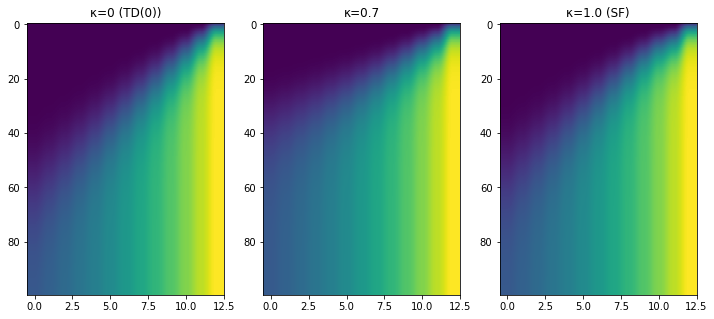

In [53]:
def script_plot_value_over_episodes():
    cur_lr = 0.2
    filter_list = [{'lr':cur_lr, 'lamb':0.0}, 
                   {'lr':cur_lr, 'lamb':0.7}, 
                   {'lr':cur_lr, 'lamb':1.0}]
    titles = ['κ=0 (TD(0))', 'κ=0.7', 'κ=1.0 (SF)']
    
    plt.figure(figsize=(12,5))
    plt.title('Value')
    
    for i, filt in enumerate(filter_list):
        curmat = script_get_lr_lamb_Wv(filt)
        
        plt.subplot(1,len(filter_list), i+1)
        
        cur_cbar = True if (i == (len(filter_list)-1)) else False
        #cur_yticklabels = True if (i == 0) else False
        #sns.heatmap(curmat, xticklabels=False, yticklabels=True,
        #            cbar=False)
        plt.imshow(curmat, aspect='auto')
        #_ = plt.ylabel('Episodes') if (i==0) else plt.ylabel('')
        #plt.xlabel('States')
        
        plt.title(titles[i])
        pass
    pass
script_plot_value_over_episodes()

### NOTE: BELOW ARE DEPRECIATED. NEED TO RE-WRITE CODE.

Episode: 0, State: 8


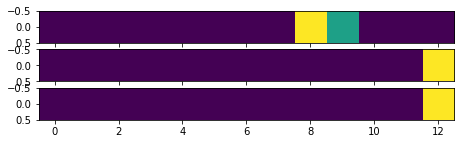

In [95]:
def script_plot_component_at_episode(data_dict, ag_key, epis_idx, state_idx):
    
    plt.figure(figsize=(8,2))
    print(f'Episode: {epis_idx}, State: {state_idx}')
    
    plt.subplot(3,1,1)
    cur_vec = In_Dict[ag_key][epis_idx]['agent']['Ws'][0,state_idx,:]
    cur_vec = cur_vec.reshape(1,13)
    plt.imshow(cur_vec)
    
    plt.subplot(3,1,2)
    cur_vec = In_Dict[ag_key][epis_idx]['agent']['Wr']
    cur_vec = cur_vec.reshape(1,13)
    plt.imshow(cur_vec)
    
    plt.subplot(3,1,3)
    cur_vec = In_Dict[ag_key][epis_idx]['agent']['Wv']
    cur_vec = cur_vec.reshape(1,13)
    plt.imshow(cur_vec)
    
    
    
script_plot_component_at_episode(In_Dict, 'SFReturnAgent_lamb-0o7', 0, 8)

Episode: 1, State: 8


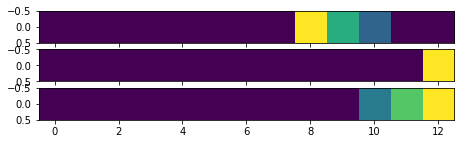

In [96]:
script_plot_component_at_episode(In_Dict, 'SFReturnAgent_lamb-0o7', 1, 8)

Seems like SF has one-step advantage since it doesn't need to learn about itself first. But, point still stands.

Episode: 1, State: 8


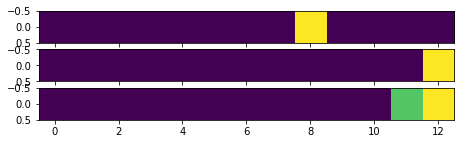

In [97]:
script_plot_component_at_episode(In_Dict, 'SFReturnAgent_lamb-0o0', 1, 8)

Episode: 1, State: 8


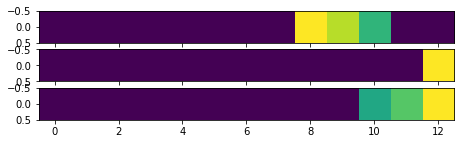

In [98]:
script_plot_component_at_episode(In_Dict, 'SFReturnAgent_lamb-1o0', 1, 8)

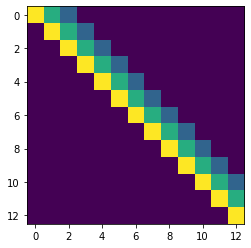

In [71]:
plt.imshow(In_Dict['SFReturnAgent_lamb-0o7'][1]['agent']['Ws'][0])